# MNIST Classification Project 🔢

This notebook aims to classify handwritten digits from the MNIST dataset, which consists of 60,000 training images and 10,000 test images. Each image is a 28x28 grayscale representation of a digit from 0 to 9. 

We will explore two different approaches for classification:
1. A fully connected neural network (DNN).
2. A convolutional neural network (CNN).

We will train both models, evaluate their performance, and compare their accuracy on the test set. The goal is to observe how different architectures perform on this image classification task.

## Importing Libraries 📚

In [2]:
import random
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.datasets import mnist
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, Input, BatchNormalization
from keras.utils import to_categorical, plot_model
from keras.optimizers import Adam, RMSprop
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.manifold import TSNE
import seaborn as sns

2024-09-25 19:57:01.422743: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


#### Fix random seeds
In order to have experiment reproductibility, it is a good practice to fix the random number generators seeds.

In [98]:
random.seed(123)
np.random.seed(123)

## Loading and Preprocessing Data 🛠️

#### Step 1 : Load the MNIST dataset

The dataset is composed of 60,000 training images and 10,000 test images. Each image is represented as a vector of 784 elements (28 x 28 pixels) and consists of grayscale values. These images have been slightly rotated, shifted, zoomed, and illuminated differently.

In [3]:
train_images = np.load('data/train_images.npy')
train_labels = np.load('data/train_labels.npy')
test_images = np.load('data/test_images.npy')
test_labels = np.load('data/test_labels.npy')

print(f"Train_image shape: {train_images.shape}")
print(f"Train_labels shape: {train_labels.shape} \n")
print(f"Test_image shape: {test_images.shape}")
print(f"Test_labels shape: {test_labels.shape}")

Train_image shape: (60000, 28, 28, 1)
Train_labels shape: (60000,) 

Test_image shape: (10000, 28, 28, 1)
Test_labels shape: (10000,)


Let‘s visualize one example per each digit : 

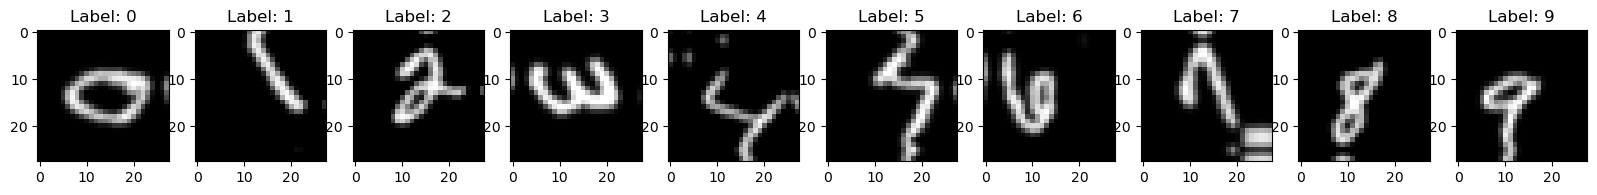

In [100]:
num_classes = 10
fig, ax = plt.subplots(1, num_classes, figsize=(20,20))

for i in range(num_classes):
  indices = np.where(train_labels == i)[0]
  if len(indices) > 0:
      # Display the first sample of the class
      sample = train_images[indices[0]]
      # Reshape the sample to a 2D image
      ax[i].imshow(sample.squeeze(), cmap="gray")
      ax[i].set_title(f"Label: {i}")
  else:
      # If there are no samples, display an empty image
      ax[i].imshow(np.zeros((28, 28)), cmap="gray")
      ax[i].set_title(f"Label: {i} (No sample)")

#### Step 2 : EDA (Exploratory Data Analysis)

1. **Image Characteristics** : We will analyze pixel intensity values, variations, and patterns.

In [101]:
def compute_class_stats(images, labels):
    stats = []
    for label in np.unique(labels):
        class_images = images[labels == label]
        mean = np.mean(class_images)
        std_dev = np.std(class_images)
        stats.append({'Class': label, 'Mean': round(mean, 3), 'Std Dev': round(std_dev, 3)})
    return pd.DataFrame(stats)

train_stats = compute_class_stats(train_images, train_labels)
test_stats = compute_class_stats(test_images, test_labels)
merged_stats = pd.merge(train_stats, test_stats, on='Class', suffixes=('_train', '_test'))

print("Before normalization :")
merged_stats


Before normalization :


,Class,Mean_train,Std Dev_train,Mean_test,Std Dev_test
0,0,0.174,0.266,43.902,67.683
1,1,0.101,0.185,26.124,47.474
2,2,0.157,0.248,39.957,63.468
3,3,0.151,0.241,37.948,61.778
4,4,0.133,0.221,32.661,56.554
5,5,0.142,0.228,36.118,58.939
6,6,0.145,0.236,37.313,61.570
7,7,0.133,0.223,33.705,56.741
8,8,0.157,0.246,40.408,63.406
9,9,0.134,0.223,34.162,57.490


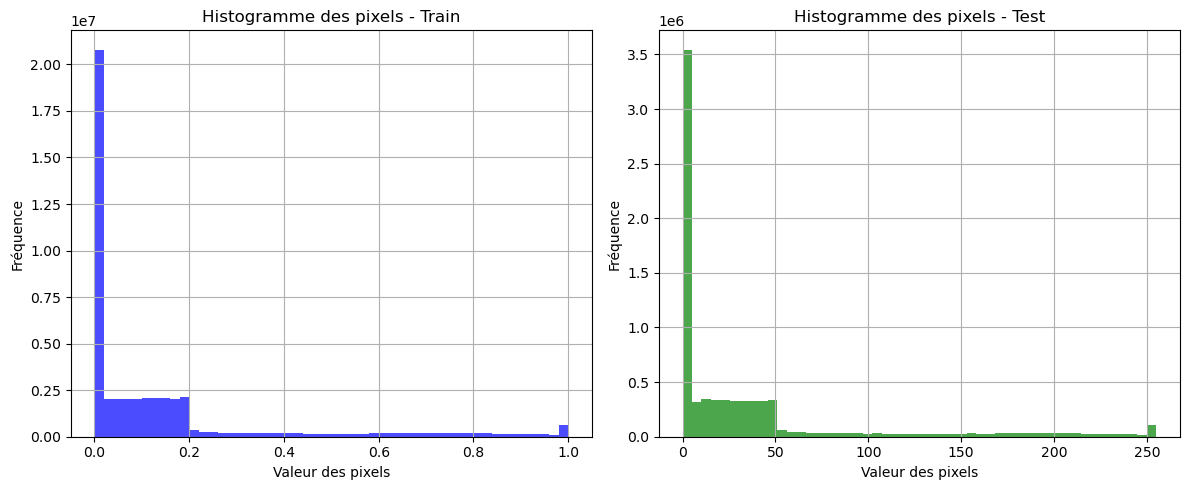

In [102]:
train_pixels = train_images.reshape(-1)  # (60000 * 28 * 28)
test_pixels = test_images.reshape(-1)    # (10000 * 28 * 28)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1) # Train
plt.hist(train_pixels, bins=50, color='blue', alpha=0.7)
plt.title('Histogramme des pixels - Train')
plt.xlabel('Valeur des pixels')
plt.ylabel('Fréquence')
plt.grid(True)

plt.subplot(1, 2, 2) # Test
plt.hist(test_pixels, bins=50, color='green', alpha=0.7)
plt.title('Histogramme des pixels - Test')
plt.xlabel('Valeur des pixels')
plt.ylabel('Fréquence')
plt.grid(True)

plt.tight_layout()
plt.show()

→ We can see that the train data seem to be centered and normalized. In cpntrast, the test data is not centered and normalized. We will do this in the next step before training the model because it is important to have the same preprocessing steps for both train and test data.

In [103]:
test_images_normalized = test_images / 255.0
test_stats = compute_class_stats(test_images_normalized, test_labels)
merged_stats = pd.merge(train_stats, test_stats, on='Class', suffixes=('_train', '_test'))
merged_stats['Mean_Diff'] = round(abs(merged_stats['Mean_train'] - merged_stats['Mean_test']), 3)
merged_stats['Std_Dev_Diff'] = round(abs(merged_stats['Std Dev_train'] - merged_stats['Std Dev_test']), 3)

print("After normalization :")
merged_stats

After normalization :


,Class,Mean_train,Std Dev_train,Mean_test,Std Dev_test,Mean_Diff,Std_Dev_Diff
0,0,0.174,0.266,0.172,0.265,0.002,0.001
1,1,0.101,0.185,0.102,0.186,0.001,0.001
2,2,0.157,0.248,0.157,0.249,0.000,0.001
3,3,0.151,0.241,0.149,0.242,0.002,0.001
4,4,0.133,0.221,0.128,0.222,0.005,0.001
5,5,0.142,0.228,0.142,0.231,0.000,0.003
6,6,0.145,0.236,0.146,0.241,0.001,0.005
7,7,0.133,0.223,0.132,0.223,0.001,0.000
8,8,0.157,0.246,0.158,0.249,0.001,0.003
9,9,0.134,0.223,0.134,0.225,0.000,0.002


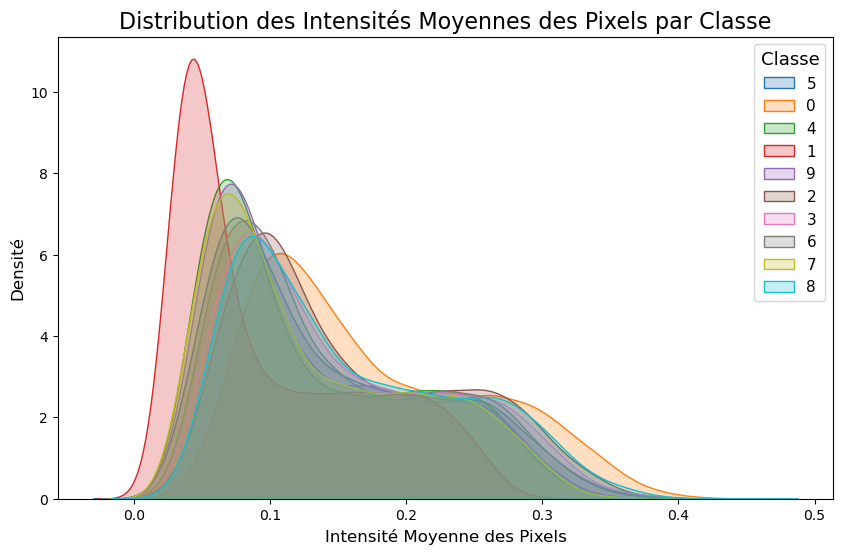

In [104]:
mean_intensities = train_images.mean(axis=(1, 2, 3))

intensity_data = pd.DataFrame({
    'Intensité Moyenne': mean_intensities,
    'Classe': train_labels
})

plt.figure(figsize=(10, 6))

for label in intensity_data['Classe'].unique():
    sns.kdeplot(data=intensity_data[intensity_data['Classe'] == label],
                 x='Intensité Moyenne',
                 label=str(label),
                 fill=True, 
                 common_norm=False)

plt.title('Distribution des Intensités Moyennes des Pixels par Classe', fontsize=16)
plt.xlabel('Intensité Moyenne des Pixels', fontsize=12)
plt.ylabel('Densité', fontsize=12)
plt.legend(title='Classe', title_fontsize='13', fontsize='11')

plt.show()

Here is density graph of the average pixel intensity for each digit, which shows that some digits have more variation in writing style than others. For example, the digit "1" is written more consistently than the digit "4" or "7". It also shows that the average pixel intensity is normally distributed for each digit.

2. **Labels Distribution** : We will analyze the distribution of the labels to prevent any class imbalance that may affect the model performance.

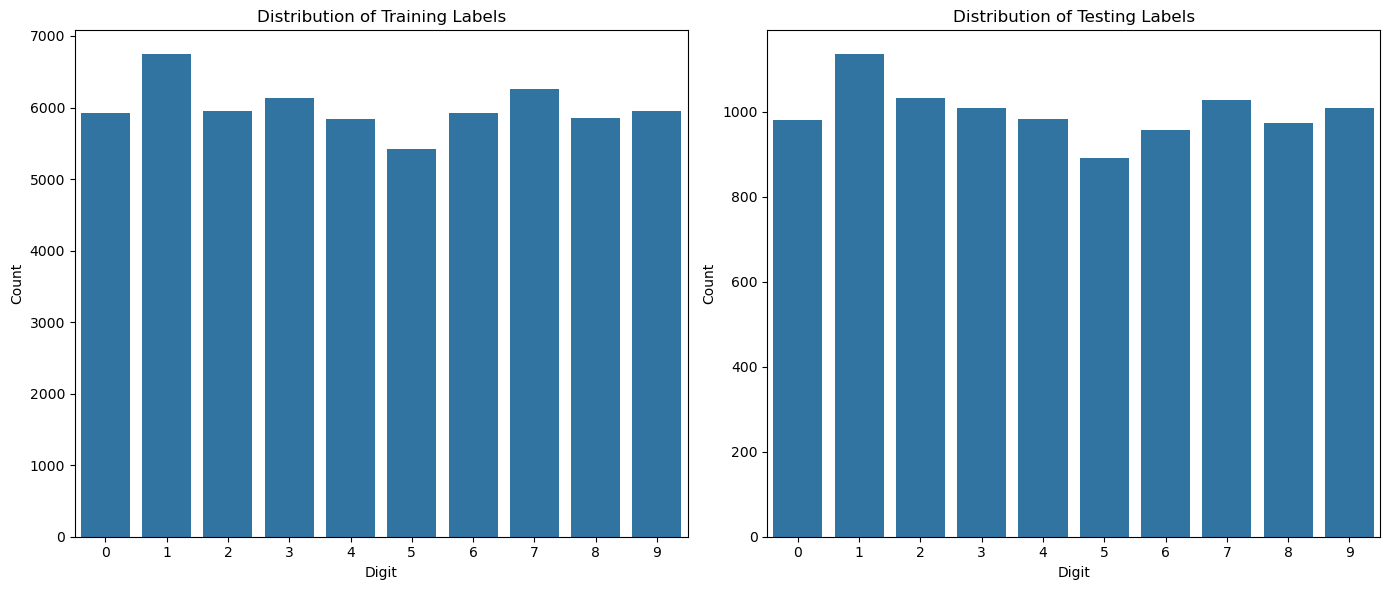

In [105]:
train_label_dist = np.bincount(train_labels)
test_label_dist = np.bincount(test_labels)
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot the distribution of training labels
sns.barplot(x=list(range(10)), y=train_label_dist, ax=axes[0])
axes[0].set_title("Distribution of Training Labels")
axes[0].set_xlabel("Digit")
axes[0].set_ylabel("Count")

# Plot the distribution of testing labels
sns.barplot(x=list(range(10)), y=test_label_dist, ax=axes[1])
axes[1].set_title("Distribution of Testing Labels")
axes[1].set_xlabel("Digit")
axes[1].set_ylabel("Count")

plt.tight_layout()
plt.show()

We can see that the labels are uniformly distributed in both the training and test sets, which is good because it prevents any class imbalance issues.

Now we want to vizualise a representant (mean of the pixel intensity) of each digit.

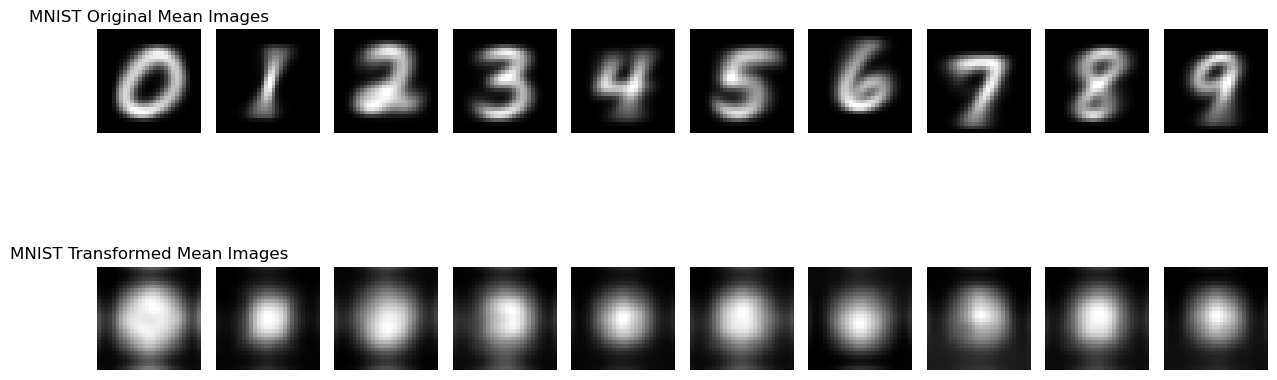

In [106]:
(train_images_mnist, train_labels_mnist), (test_images_mnist, test_labels_mnist) = mnist.load_data()

def get_class_arrays(class_index, train_image, train_label):
    return train_image[train_label == class_index], train_label[train_label == class_index]

mean_images_mnist = np.zeros((10, 28, 28))
for i in range(10):
    class_arrayX, class_arrayY = get_class_arrays(i, train_images_mnist, train_labels_mnist)
    mean_images_mnist[i] = class_arrayX.mean(axis=0)

mean_images_custom = np.zeros((10, 28, 28))
for i in range(10):
    class_arrayX, class_arrayY = get_class_arrays(i, train_images, train_labels)
    class_arrayX = class_arrayX.squeeze()  
    mean_images_custom[i] = class_arrayX.mean(axis=0)
plt.figure(figsize=(12, 6))
plt.subplot(2, 10, 1)
plt.title("MNIST Original Mean Images")
plt.axis("off")

for i in range(10):
    plt.subplot(2, 10, i + 1)
    plt.imshow(mean_images_mnist[i], cmap='gray')
    plt.axis("off")
plt.subplot(2, 10, 11)
plt.title("MNIST Transformed Mean Images")
plt.axis("off")

for i in range(10):
    plt.subplot(2, 10, i + 11)
    plt.imshow(mean_images_custom[i], cmap='gray')
    plt.axis("off")
plt.tight_layout()
plt.show()

We can see that the digits, wich have been transformed with random rotations, shifts, zooms, and illuminations, are not recognizable as the original digits. This may make the classification task more challenging.

#### Step 3 : Preprocess the Data

1. **Normalization**: We will normalize the pixel values of the images to be in the range [0, 1]. This involves dividing each pixel value by 255 (since the maximum pixel value is 255). Only for the test data because the train data is already normalized.

In [107]:
test_images = test_images / 255.0

Now we will one-hot encode the labels for our classification task. This means that each label will be represented as a 10-dimensional vector with all elements being zero except for the index corresponding to the class label, which will be 1.

In [108]:
train_labels = to_categorical(train_labels, 10)
test_labels = to_categorical(test_labels, 10)

#### Step 4 : Split the Data

We will split the training data into training and validation sets. The training set will contain 80% of the data, while the validation set will contain 20%. This will allow us to train the model on the training set and validate it on the validation set to prevent overfitting.

In [109]:
X_train, X_val, y_train, y_val = train_test_split(train_images, train_labels, test_size=0.2, random_state=42, shuffle=True)

Let's visualize the space of the data using PCA :


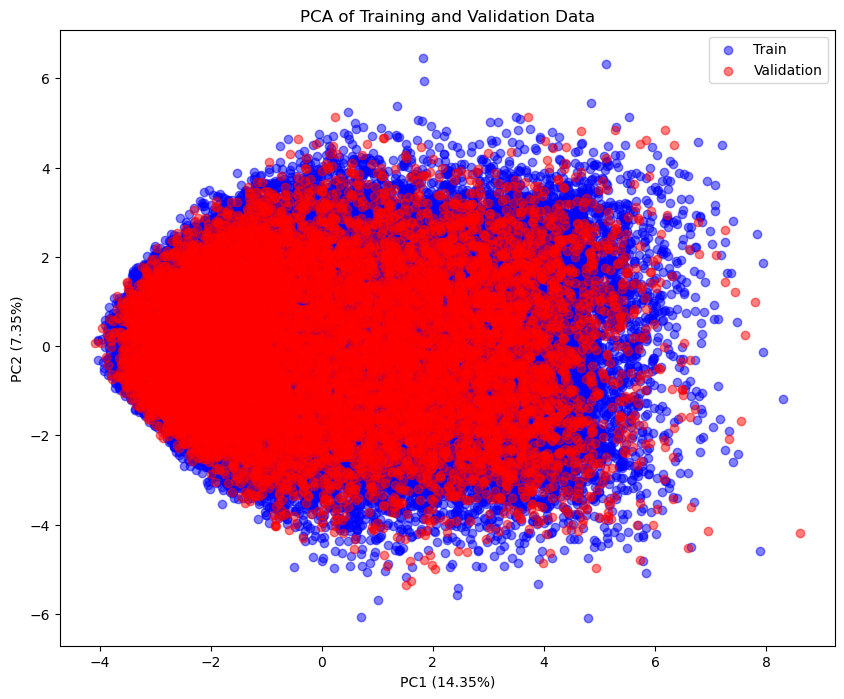

In [110]:
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_val_flat = X_val.reshape(X_val.shape[0], -1)
combined_data = np.vstack([X_train_flat, X_val_flat])
combined_labels = np.hstack([np.full(X_train.shape[0], 'Train'), np.full(X_val.shape[0], 'Validation')])
pca = PCA(n_components=2)
pca_result = pca.fit_transform(combined_data)
explained_variance = pca.explained_variance_ratio_

plt.figure(figsize=(10, 8))
plt.scatter(pca_result[:X_train.shape[0], 0], pca_result[:X_train.shape[0], 1], c='blue', label='Train', alpha=0.5)
plt.scatter(pca_result[X_train.shape[0]:, 0], pca_result[X_train.shape[0]:, 1], c='red', label='Validation', alpha=0.5)
plt.title('PCA of Training and Validation Data')
plt.xlabel(f'PC1 ({explained_variance[0] * 100:.2f}%)')
plt.ylabel(f'PC2 ({explained_variance[1] * 100:.2f}%)')
plt.legend()
plt.show()

## Fully Connected Neural Network (DNN) 🧠

#### Building the Model 🧱 

First we will build a fully connected neural network with 3 hidden layers. The input layer will have 784 neurons (one for each pixel), and the output layer will have 10 neurons (one for each digit). We will use the ReLU activation function for the hidden layers and the softmax activation function for the output layer.

In [162]:
fc_model = Sequential()
fc_model.add(Input(shape=(784,)))
fc_model.add(Dense(256, activation='relu'))
fc_model.add(Dropout(0.3))
fc_model.add(Dense(128, activation='relu'))
fc_model.add(Dropout(0.3))
fc_model.add(Dense(10, activation='softmax'))

learning_rate = 0.001
optimizer = RMSprop(learning_rate=learning_rate)

fc_model.compile(optimizer=optimizer,
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])

fc_model.summary()

Model: "sequential_28"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_76 (Dense)                │ (None, 256)            │       200,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_51 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_77 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_52 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_78 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 235,146 (918.54 KB)

 Trainable params: 235,146 (918.54 KB)

 Non-trainable params: 0 (0.00 B)

### Training the Model 🏋️

In [163]:
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_val_flat = X_val.reshape(X_val.shape[0], -1)
fc_history = fc_model.fit(X_train_flat, y_train, epochs=15, batch_size= 128, validation_data=(X_val_flat, y_val))

Epoch 1/15
375/375 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.2506 - loss: 2.0690 - val_accuracy: 0.5418 - val_loss: 1.4083
Epoch 2/15
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5054 - loss: 1.4551 - val_accuracy: 0.6541 - val_loss: 1.0893
Epoch 3/15
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5952 - loss: 1.2230 - val_accuracy: 0.6935 - val_loss: 0.9751
Epoch 4/15
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6377 - loss: 1.0951 - val_accuracy: 0.7215 - val_loss: 0.8853
Epoch 5/15
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.6699 - loss: 1.0059 - val_accuracy: 0.7312 - val_loss: 0.8375
Epoch 6/15
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.6855 - loss: 0.9582 - val_accuracy: 0.7592 - val_loss: 0.7902
Epoch 7/15
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.7095 - loss: 0.9006 - val_accuracy: 0.7688 - val_loss: 0.7378
Epoch 8/15
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.7167 - loss: 0.8689 - val_accuracy: 0.

### Evaluating the Model 📏

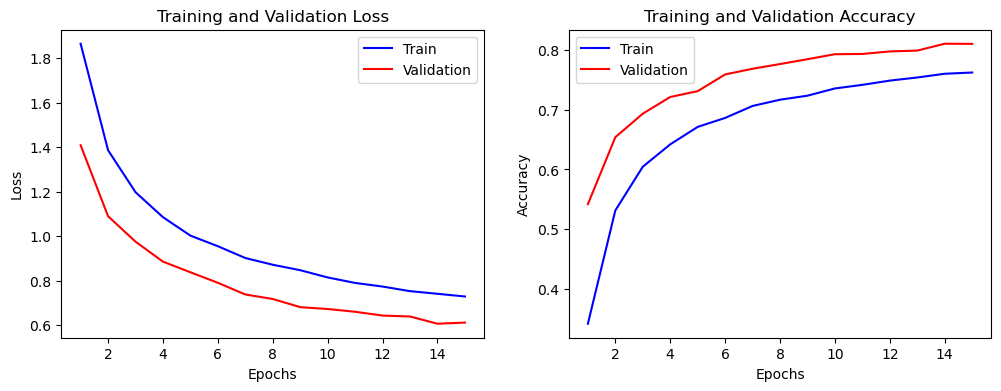

In [164]:
def plot_training_history(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    
    epochs = range(1, len(loss) + 1)
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, 'b-', label='Train')
    plt.plot(epochs, val_loss, 'r-', label='Validation')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    # Tracer la précision
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, 'b-', label='Train')
    plt.plot(epochs, val_accuracy, 'r-', label='Validation')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

plot_training_history(fc_history)


In [165]:
test_loss, test_accuracy = fc_model.evaluate(test_images.reshape(test_images.shape[0], -1), test_labels)

print(f"Test Loss: {test_loss:.3f}")
print(f"Test Accuracy: {test_accuracy*100:.3f} %")

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8084 - loss: 0.6230
Test Loss: 0.581
Test Accuracy: 82.090 %


In [166]:
# Confusion matrix
def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title=None, cmap=plt.cm.Blues):
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], fmt),
                     ha="center", va="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


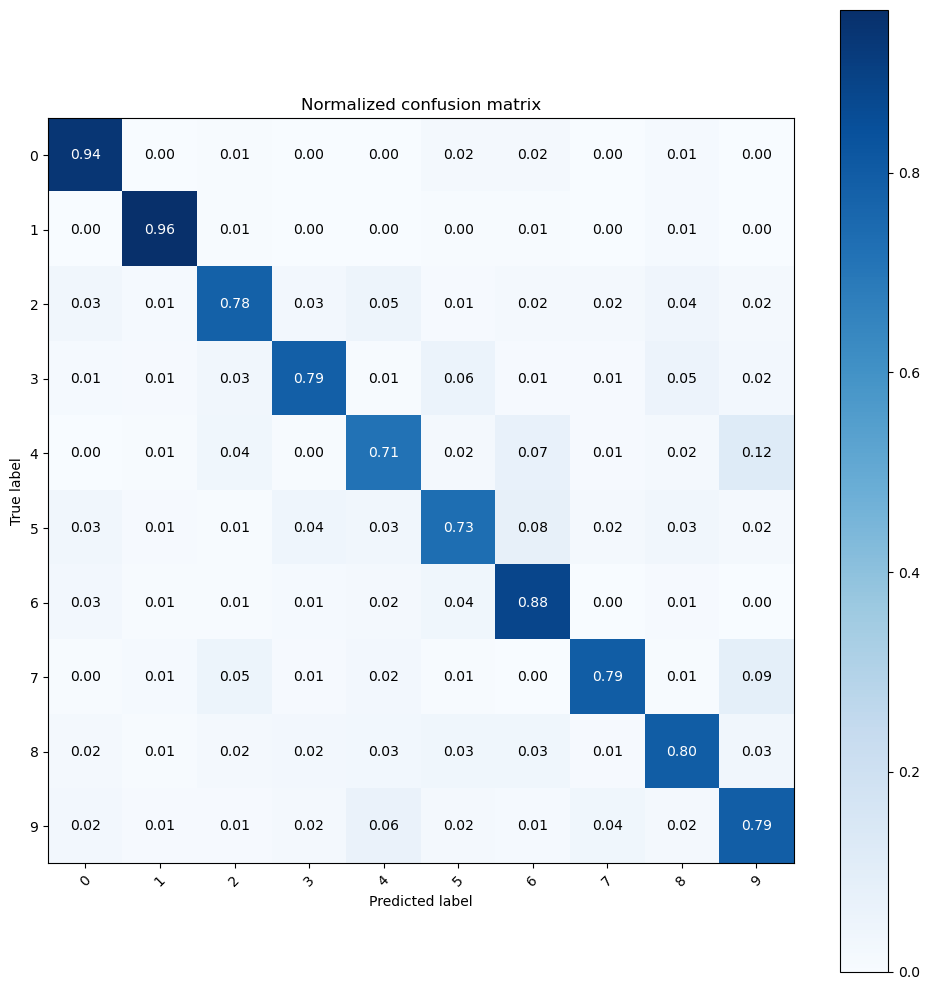

In [167]:
# plot
y_pred = np.argmax(fc_model.predict(test_images.reshape(test_images.shape[0], -1)), axis=1)
y_true = np.argmax(test_labels, axis=1)
plot_confusion_matrix(y_true, y_pred, classes=range(10), normalize=True, title='Normalized confusion matrix')

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


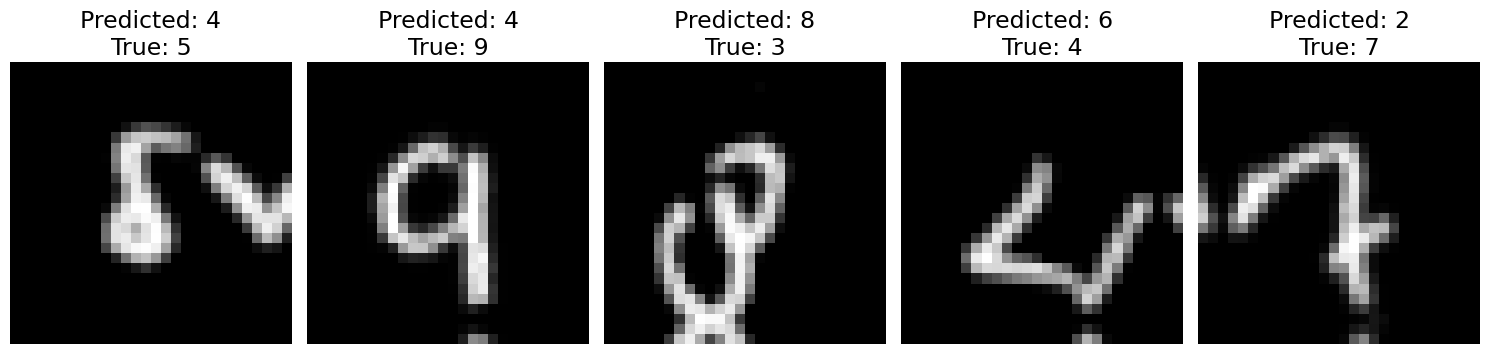

In [214]:
y_pred = np.argmax(fc_model.predict(test_images.reshape(test_images.shape[0], -1)), axis=1)
y_true = np.argmax(test_labels, axis=1)

error_indices = np.where(y_pred != y_true)[0]
error_images = test_images[error_indices]
error_predictions = y_pred[error_indices]
error_true_labels = y_true[error_indices]

def plot_top_errors(images, true_labels, pred_labels, num_errors=5):
    plt.figure(figsize=(15, 5))
    for i in range(num_errors):
        plt.subplot(1, num_errors, i + 1)
        plt.imshow(images[i].reshape(28, 28), cmap='gray')
        plt.title(f'Predicted: {pred_labels[i]}\nTrue: {true_labels[i]}', fontsize=17)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

plot_top_errors(error_images[:5], error_true_labels[:5], error_predictions[:5])

## Convolutional Neural Network (CNN) 🖼️

#### Building the Model 🧱 

In [175]:
cnn_model_1 = Sequential()
cnn_model_1.add(Input(shape=(28,28,1)))
cnn_model_1.add(Conv2D(128, (3, 3), activation='relu'))
cnn_model_1.add(MaxPooling2D((2, 2)))
cnn_model_1.add(Conv2D(32, (3, 3), activation='relu'))
cnn_model_1.add(MaxPooling2D((2, 2)))
cnn_model_1.add(Flatten())
cnn_model_1.add(Dropout(0.3))
cnn_model_1.add(Dense(10, activation='softmax'))

optimizer = Adam(learning_rate=0.001)

cnn_model_1.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

cnn_model_1.summary()

Model: "sequential_31"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 26, 26, 128)    │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 13, 13, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 11, 11, 32)     │        36,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 5, 5, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 800)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_57 (Dropout)            │ (None, 800)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_82 (Dense)                │ (None, 10)             │         8,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 46,186 (180.41 KB)

 Trainable params: 46,186 (180.41 KB)

 Non-trainable params: 0 (0.00 B)

### Training the Model 🏋️

In [176]:
cnn_history = cnn_model_1.fit(X_train, y_train, epochs=15, batch_size=64, validation_data=(X_val, y_val))

Epoch 1/15
750/750 ━━━━━━━━━━━━━━━━━━━━ 98s 129ms/step - accuracy: 0.3093 - loss: 1.9137 - val_accuracy: 0.6930 - val_loss: 1.0076
Epoch 2/15
750/750 ━━━━━━━━━━━━━━━━━━━━ 98s 130ms/step - accuracy: 0.6586 - loss: 1.0504 - val_accuracy: 0.7994 - val_loss: 0.6963
Epoch 3/15
750/750 ━━━━━━━━━━━━━━━━━━━━ 141s 129ms/step - accuracy: 0.7413 - loss: 0.8130 - val_accuracy: 0.8293 - val_loss: 0.5946
Epoch 4/15
750/750 ━━━━━━━━━━━━━━━━━━━━ 97s 129ms/step - accuracy: 0.7800 - loss: 0.7024 - val_accuracy: 0.8526 - val_loss: 0.5109
Epoch 5/15
750/750 ━━━━━━━━━━━━━━━━━━━━ 136s 120ms/step - accuracy: 0.8021 - loss: 0.6298 - val_accuracy: 0.8734 - val_loss: 0.4441
Epoch 6/15
750/750 ━━━━━━━━━━━━━━━━━━━━ 152s 134ms/step - accuracy: 0.8146 - loss: 0.5864 - val_accuracy: 0.8819 - val_loss: 0.4149
Epoch 7/15
750/750 ━━━━━━━━━━━━━━━━━━━━ 144s 137ms/step - accuracy: 0.8199 - loss: 0.5687 - val_accuracy: 0.8842 - val_loss: 0.3984
Epoch 8/15
750/750 ━━━━━━━━━━━━━━━━━━━━ 100s 133ms/step - accuracy: 0.8289 - lo

### Evaluating the Model 📏

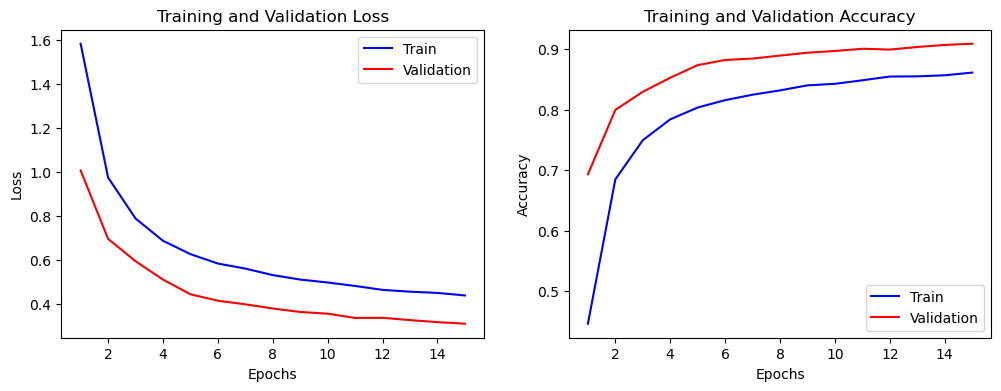

In [177]:
plot_training_history(cnn_history)

In [181]:
test_loss, test_accuracy = cnn_model_1.evaluate(test_images, test_labels)

print(f"Test Loss: {test_loss:.3f}")
print(f"Test Accuracy: {test_accuracy*100:.3f} %")

313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.9054 - loss: 0.3199
Test Loss: 0.295
Test Accuracy: 91.340 %


313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step


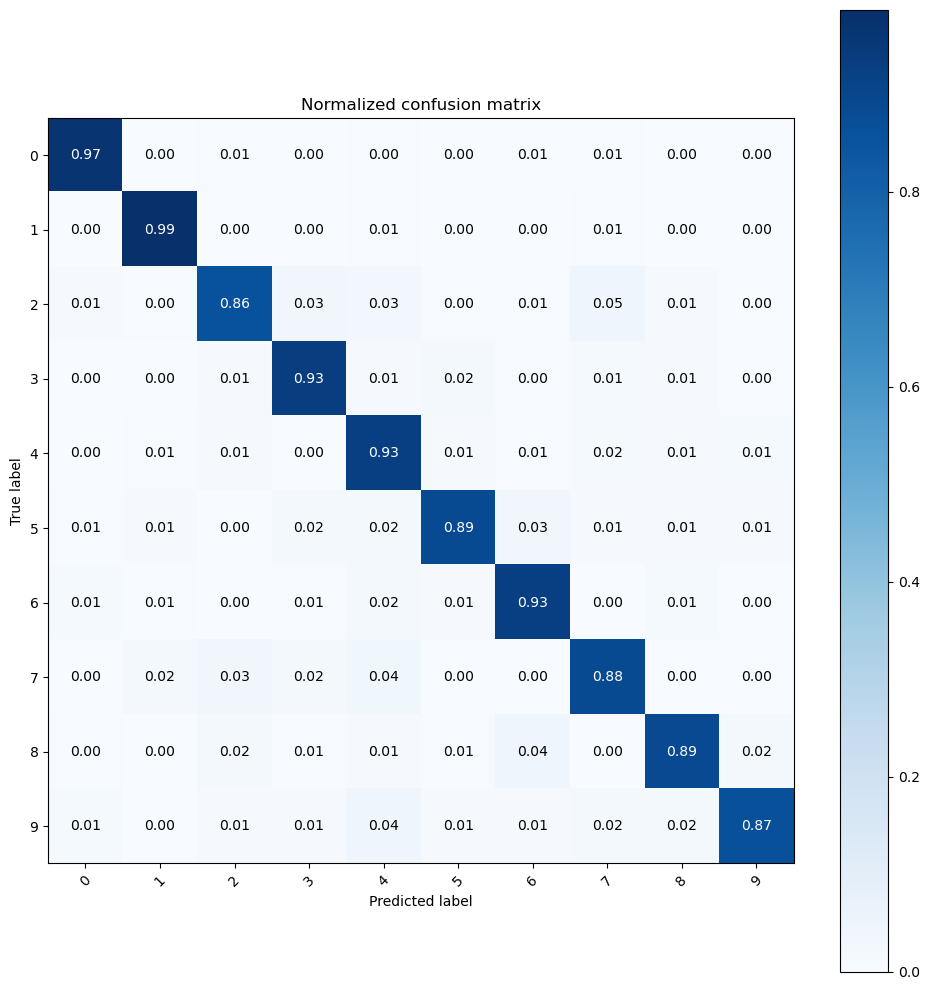

In [185]:
# plot
y_pred = np.argmax(cnn_model_1.predict(test_images), axis=1)
y_true = np.argmax(test_labels, axis=1)
plot_confusion_matrix(y_true, y_pred, classes=range(10), normalize=True, title='Normalized confusion matrix')

313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step


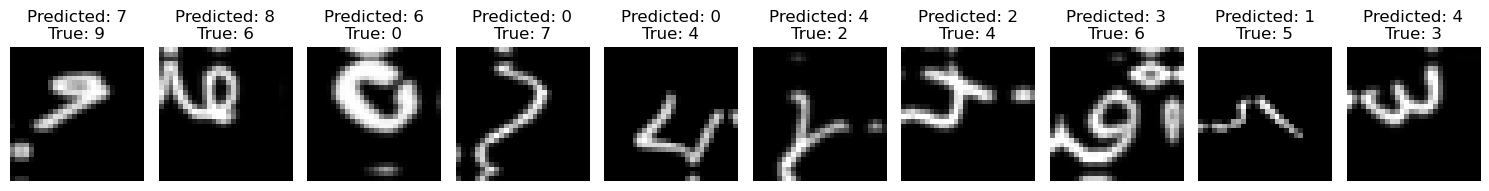

In [187]:
y_pred = np.argmax(cnn_model_1.predict(test_images), axis=1)
y_true = np.argmax(test_labels, axis=1)

error_indices = np.where(y_pred != y_true)[0]
error_images = test_images[error_indices]
error_predictions = y_pred[error_indices]
error_true_labels = y_true[error_indices]

def plot_top_errors(images, true_labels, pred_labels, num_errors=5):
    plt.figure(figsize=(15, 5))
    for i in range(num_errors):
        plt.subplot(1, num_errors, i + 1)
        plt.imshow(images[i].reshape(28, 28), cmap='gray')
        plt.title(f'Predicted: {pred_labels[i]}\nTrue: {true_labels[i]}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

plot_top_errors(error_images[:10], error_true_labels[:10], error_predictions[:10], 10)

### Optimize the Model 🛠️

In [198]:
cnn_model_2 = Sequential()
cnn_model_2.add(Input(shape=(28,28,1)))
cnn_model_2.add(Conv2D(128, (3, 3), activation='relu'))
cnn_model_2.add(BatchNormalization())
cnn_model_2.add(MaxPooling2D((2, 2)))
cnn_model_2.add(Conv2D(64, (3, 3), activation='relu'))  
cnn_model_2.add(BatchNormalization())
cnn_model_2.add(MaxPooling2D((2, 2)))
cnn_model_2.add(Flatten())  
cnn_model_2.add(Dropout(0.3))
cnn_model_2.add(Dense(128, activation='relu'))
cnn_model_2.add(Dropout(0.3))
cnn_model_2.add(Dense(10, activation='softmax'))

optimizer = Adam(learning_rate=0.001)

cnn_model_2.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

cnn_model_2.summary()

Model: "sequential_38"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_15 (Conv2D)              │ (None, 26, 26, 128)    │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 26, 26, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 13, 13, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 11, 11, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 11, 11, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_60 (Dropout)            │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_85 (Dense)                │ (None, 128)            │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_61 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_86 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 282,058 (1.08 MB)

 Trainable params: 281,674 (1.07 MB)

 Non-trainable params: 384 (1.50 KB)

### Training the Model 🏋️

In [199]:
# Callbacks
lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.00001)
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

In [200]:
cnn_history_bis = cnn_model_2.fit(X_train, y_train, epochs=15, batch_size=32, validation_data=(X_val, y_val), callbacks=[lr_reducer, early_stopping])
#cnn_history_bis = cnn_model_2.fit(X_train, y_train, epochs=15, batch_size=64, validation_data=(X_val, y_val), callbacks=[lr_reducer, early_stopping])
#cnn_history_bis = cnn_model_2.fit(X_train, y_train, epochs=15, batch_size=128, validation_data=(X_val, y_val), callbacks=[lr_reducer, early_stopping])

Epoch 1/15
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 200s 131ms/step - accuracy: 0.4124 - loss: 1.7411 - val_accuracy: 0.8657 - val_loss: 0.4537 - learning_rate: 0.0010
Epoch 2/15
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 211s 141ms/step - accuracy: 0.8157 - loss: 0.5822 - val_accuracy: 0.9018 - val_loss: 0.3399 - learning_rate: 0.0010
Epoch 3/15
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 222s 148ms/step - accuracy: 0.8700 - loss: 0.4102 - val_accuracy: 0.9078 - val_loss: 0.3060 - learning_rate: 0.0010
Epoch 4/15
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 204s 136ms/step - accuracy: 0.8930 - loss: 0.3395 - val_accuracy: 0.9364 - val_loss: 0.2083 - learning_rate: 0.0010
Epoch 5/15
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 282s 150ms/step - accuracy: 0.9064 - loss: 0.2957 - val_accuracy: 0.9440 - val_loss: 0.1864 - learning_rate: 0.0010
Epoch 6/15
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 263s 150ms/step - accuracy: 0.9146 - loss: 0.2635 - val_accuracy: 0.9477 - val_loss: 0.1764 - learning_rate: 0.0010
Epoch 7/15
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 262s 151ms

### Evaluating the Model 📏

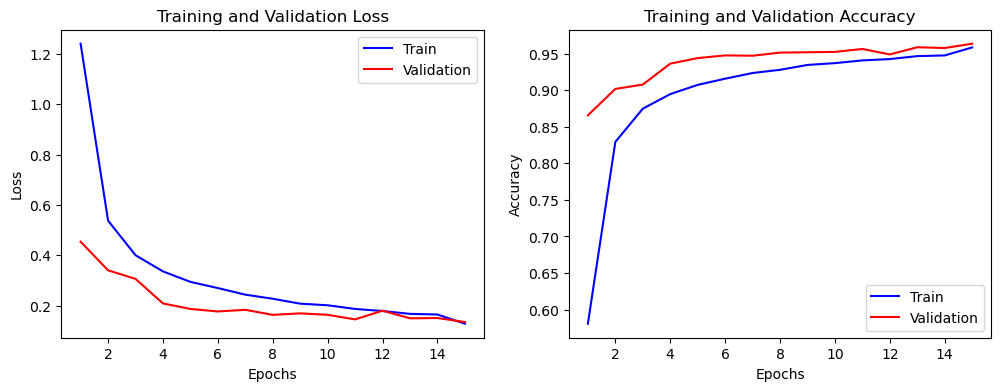

In [201]:
plot_training_history(cnn_history_bis)

In [203]:
test_loss, test_accuracy = cnn_model_2.evaluate(test_images, test_labels)

print(f"Test Loss: {test_loss:.3f}")
print(f"Test Accuracy: {test_accuracy*100:.3f} %")

313/313 ━━━━━━━━━━━━━━━━━━━━ 12s 37ms/step - accuracy: 0.9646 - loss: 0.1230
Test Loss: 0.113
Test Accuracy: 96.730 %


313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step


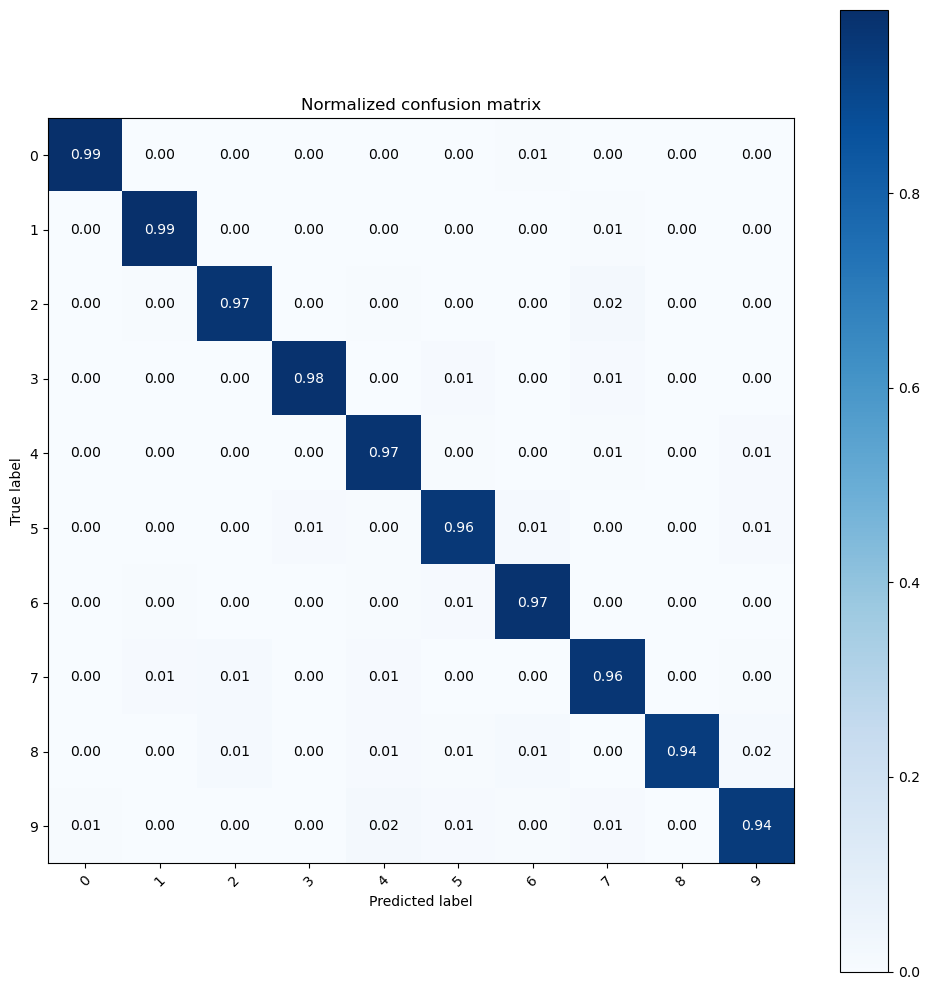

In [204]:
# plot
y_pred = np.argmax(cnn_model_2.predict(test_images), axis=1)
y_true = np.argmax(test_labels, axis=1)
plot_confusion_matrix(y_true, y_pred, classes=range(10), normalize=True, title='Normalized confusion matrix')

313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step


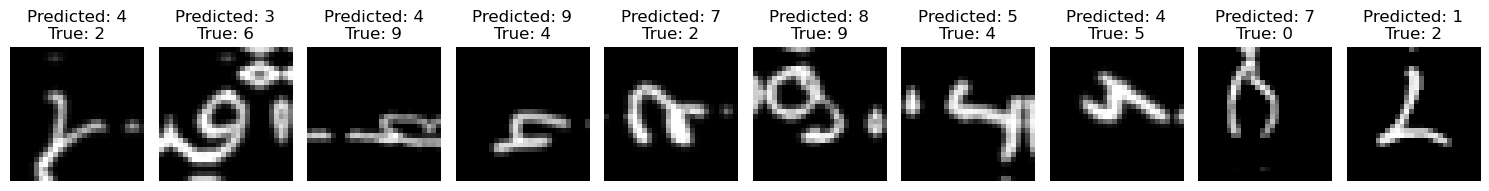

In [205]:
y_pred = np.argmax(cnn_model_2.predict(test_images), axis=1)
y_true = np.argmax(test_labels, axis=1)

error_indices = np.where(y_pred != y_true)[0]
error_images = test_images[error_indices]
error_predictions = y_pred[error_indices]
error_true_labels = y_true[error_indices]

def plot_top_errors(images, true_labels, pred_labels, num_errors=5):
    plt.figure(figsize=(15, 5))
    for i in range(num_errors):
        plt.subplot(1, num_errors, i + 1)
        plt.imshow(images[i].reshape(28, 28), cmap='gray')
        plt.title(f'Predicted: {pred_labels[i]}\nTrue: {true_labels[i]}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

plot_top_errors(error_images[:10], error_true_labels[:10], error_predictions[:10], 10)